# LOAD DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [2]:
INPUT_FILE = 'ranking/BERT_eval.txt'
WITH_QRELS = 'data/text/eval_summarized_200.csv'


In [3]:

scores = pd.read_csv(INPUT_FILE).set_index(['case_id', 'candidate_id'])
original = pd.read_csv(WITH_QRELS).set_index(['case_id', 'candidate_id'])
full_mix = scores.join(original).reset_index()[['case_id', 'candidate_id', 'score', 'candidate_is_noticed']]

nb_rels = {}
for case_id, rel in full_mix[full_mix['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
    nb_rels[case_id] = rel
print('Average number of rels per case: {:0.2f}'.format(np.mean([v for _,v in nb_rels.items()])))



Average number of rels per case: 4.80


# Restrict to only the test cases
test_cases = pd.read_csv('test_cases_id.csv', names=['case_id'], header=None).set_index('case_id')
test_mix = full_mix.set_index('case_id').join(test_cases, how='inner').reset_index()
train_mix = full_mix[~full_mix['case_id'].isin(test_cases.reset_index()['case_id'])].reset_index()



In [4]:
# if only the TEST was predicted, (in this case TEST means EVAL: we know the qrels)
test_mix = full_mix

number_candidates= 200
number_cases = len(test_mix['case_id'].unique())

print('mix: {}'.format(test_mix.shape))
print('Number of cases: {}'.format(number_cases))



mix: (15200, 4)
Number of cases: 76


# VIZ

## Distribution of RELS per case

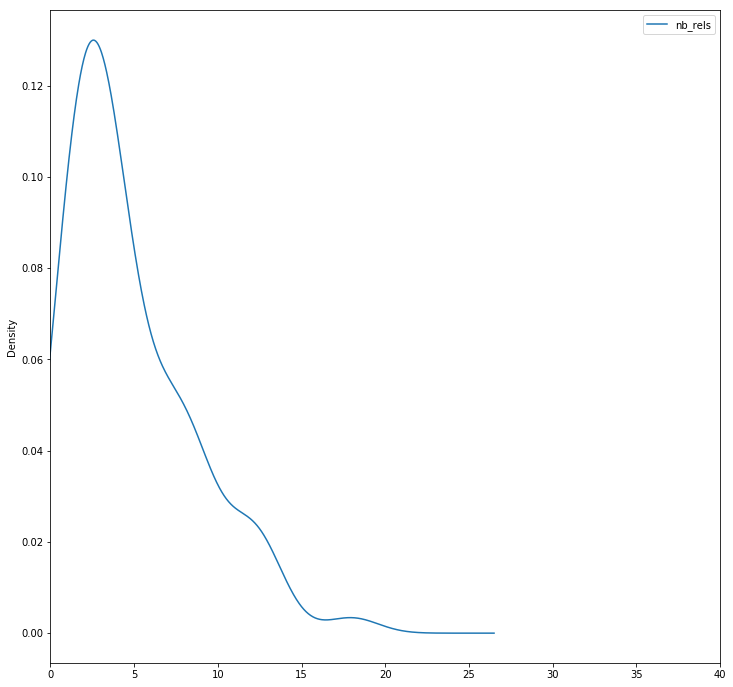

In [5]:
rels_df = pd.DataFrame.from_dict(nb_rels, orient='index', columns=['nb_rels'])
_ = rels_df.plot.kde(xlim=(0,40), figsize=(12,12))

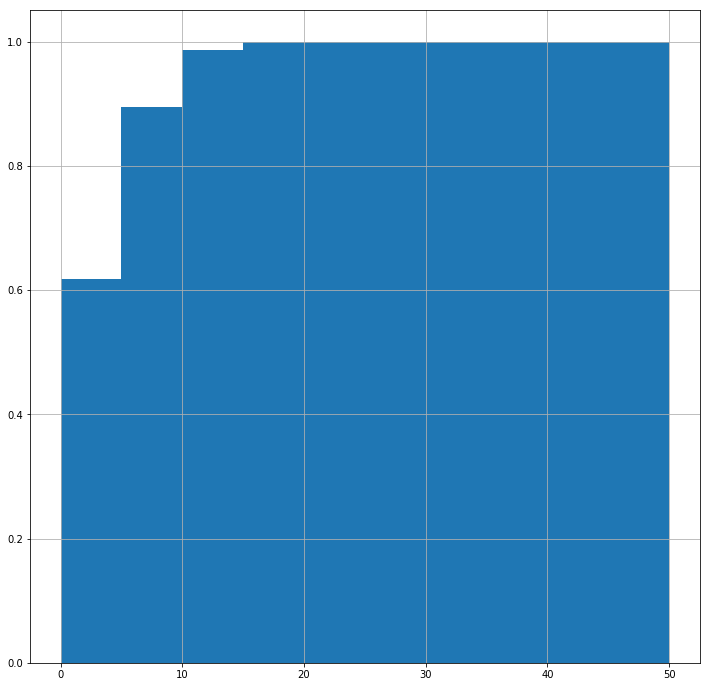

In [6]:
plt.figure(figsize=(12,12))
_ = plt.hist(x=rels_df['nb_rels'], bins=[i*5 for i in range(0,11)], density=True, cumulative=True)
plt.grid()

In [7]:
print("Average rels: {:.2f}".format(sum([v for _,v in nb_rels.items()]) / len(nb_rels)))

Average rels: 4.80


## For the test data, the distribution of scores with regards to the true class

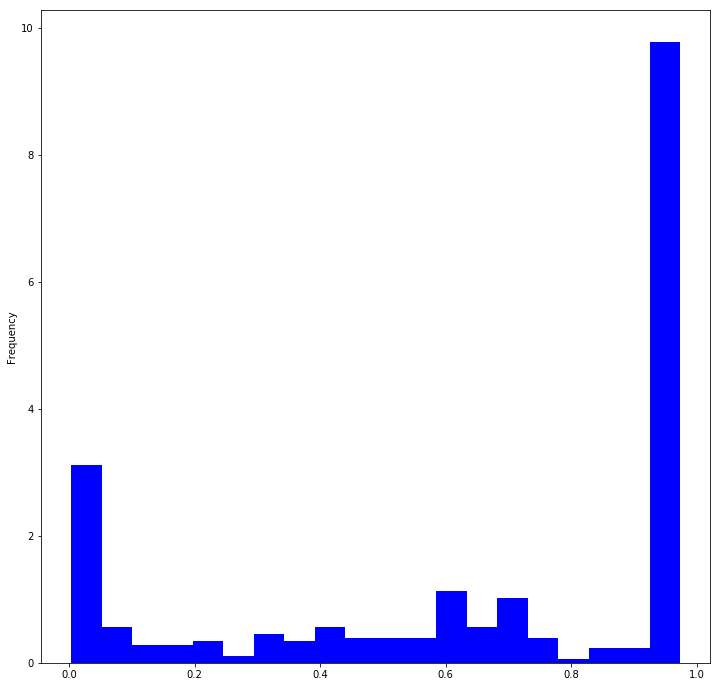

In [8]:
_ = test_mix[test_mix['candidate_is_noticed'] == True]['score'].plot.hist(bins=20, color='blue', figsize=(12,12), density=True)


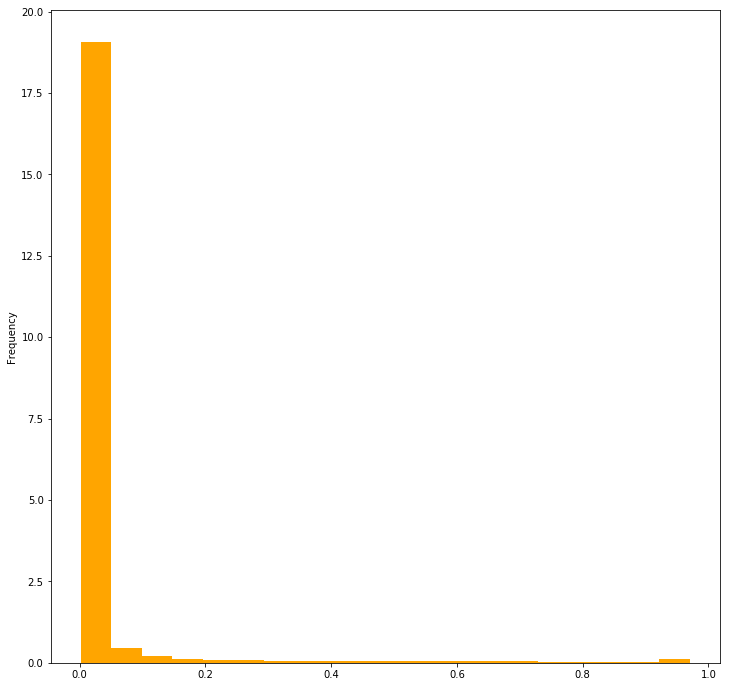

In [9]:
_ = test_mix[test_mix['candidate_is_noticed'] == False]['score'].plot.hist(bins=20, color='orange',  figsize=(12,12), density=True)


Text(0.5, 0, '')

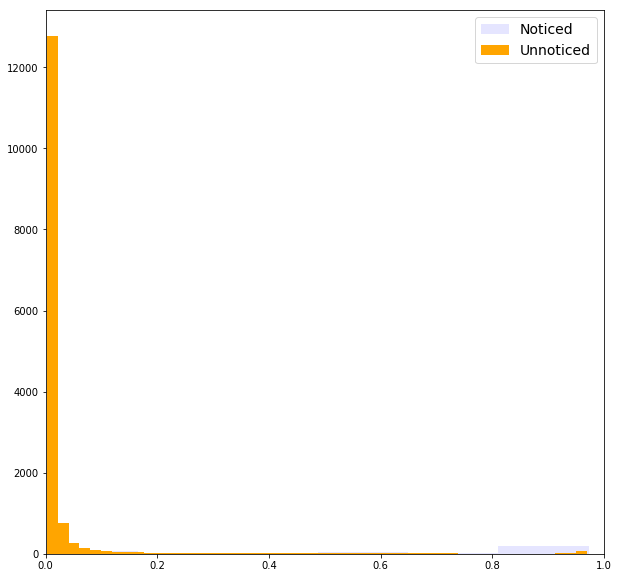

In [10]:
# List of five airlines to plot
labels = [True, False]
texts = {True: 'Noticed', False:'Unnoticed'}
colors_01 = {True: 'blue', False: 'orange'}
colors_02 = {k: colors_01[not k] for k in colors_01}
alphas_01 = {True: 0.1, False: 1}
alphas_02 = {k: alphas_01[not k] for k in alphas_01}
plt.figure(figsize=(10,10))

colors = colors_01
alphas = alphas_01

for label in labels:
    # Subset to the airline
    subset = test_mix[test_mix['candidate_is_noticed'] == label]

    # Draw the density plot
    ax = sns.distplot(subset['score'], hist = True, kde = False,
                 kde_kws = {'linewidth': 3, 'shade': True},
                 hist_kws = {'histtype': 'stepfilled', 'color': colors[label], 'alpha': alphas[label]},
                 label = texts[label])
    ax.set_xlim((0.0,1.0))

# Plot formatting
plt.legend(prop={'size': 14})
plt.title('')
plt.xlabel('')
#plt.ylabel('')
#plt.yticks([])

Text(0.5, 0, '')

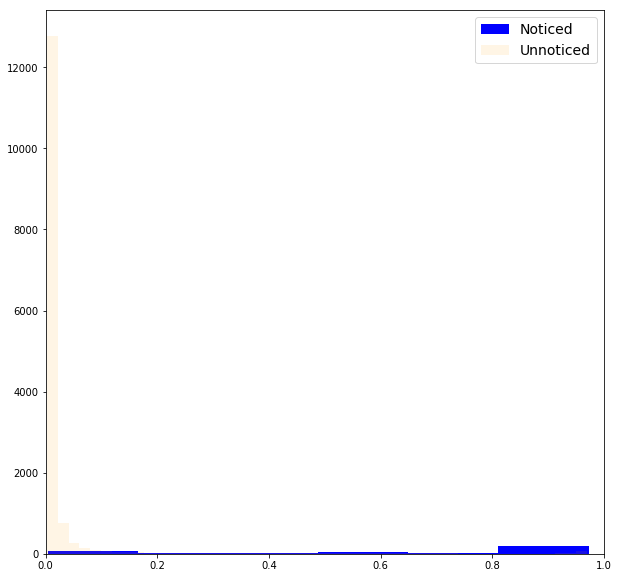

In [11]:
colors = colors_01
alphas = alphas_02

plt.figure(figsize=(10,10))

for label in labels:
    # Subset to the airline
    subset = test_mix[test_mix['candidate_is_noticed'] == label]

    # Draw the density plot
    ax = sns.distplot(subset['score'], hist = True, kde = False,
                 kde_kws = {'linewidth': 3, 'shade': True},
                 hist_kws = {'histtype': 'stepfilled', 'color': colors[label], 'alpha': alphas[label]},
                 label = texts[label])
    ax.set_xlim((0.0,1.0))

# Plot formatting
plt.legend(prop={'size': 14})
plt.title('')
plt.xlabel('')
#plt.ylabel('')
#plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

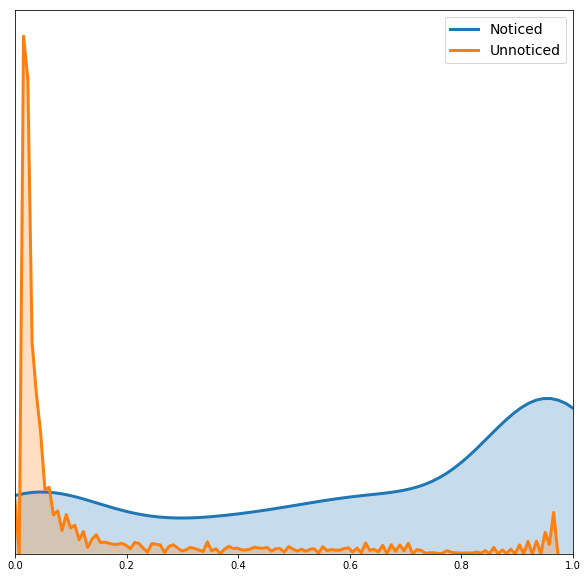

In [12]:
plt.figure(figsize=(10,10))

for label in labels:
    # Subset to the airline
    subset = test_mix[test_mix['candidate_is_noticed'] == label]

    # Draw the density plot
    ax = sns.distplot(subset['score'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'shade': True},
                 label = texts[label])
    ax.set_xlim((0.0,1.0))

# Plot formatting
plt.legend(prop={'size': 14})
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

## For the TRAIN data, separate plots for POSITIVE class / NEGATIVE class

In [ ]:
sample_train = train_mix
_ = sample_train[sample_train['candidate_is_noticed'] == True]['score'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='blue', figsize=(12,12))


In [ ]:
_ = sample_train[sample_train['candidate_is_noticed'] == False]['score'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='orange',  figsize=(12,12))


# CUTTING BY SCORE

In [13]:

cuts = []
found_at_cut = {}
returned_at_cut = {}
for cut in np.arange(0.0, 1.0, 0.0001):
    cut = float('{:.4f}'.format(cut))
    
    results = test_mix[test_mix['score'] > cut]

    nb_found = {}
    nb_returned = {}

    # If empty dataframe (ie : there is no candidate with a higher score than the cut)
    if len(results) == 0:
        avg_r = 0
        avg_p = 0
        avg_f1 = 0
    else:
        for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_found[case_id] = found
        for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_returned[case_id] = returned

        recall = {}
        precision = {}
        f1 = {}

        for case_id, rels in nb_rels.items():
            found = nb_found[case_id] if case_id in nb_found else 0
            returned = nb_returned[case_id] if case_id in nb_returned else 0
            r = found / rels
            p = found / returned if returned > 0 else 0
            recall[case_id] = r
            precision[case_id] = p
            f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        # MACRO Average
        #avg_r = sum([v for _,v in recall.items()]) / len(recall)
        #avg_p = sum([v for _,v in precision.items()]) / len(precision)
        #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p) if (avg_r + avg_p) > 0 else 0

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut, avg_r, avg_p, avg_f1])
    found_at_cut[cut] = nb_found
    returned_at_cut[cut] = nb_returned
    
cuts_df = pd.DataFrame(cuts, columns=['cut', 'r', 'p', 'f1'])
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, cuts_df.sort_values(metric, ascending=False)[['cut', metric]][:1]))

# Best at F1
best_f1 = cuts_df.sort_values('f1', ascending=False)[['cut', metric]][:1]['cut'].values[0]
print('Values at best cut: R={:0.2f} P={:0.2f}'.format(cuts_df[cuts_df['cut'] == best_f1]['r'].values[0], 
                                                       cuts_df[cuts_df['cut'] == best_f1]['p'].values[0]))

Best cut for r: 
   cut    r
0  0.0  1.0

Best cut for p: 
         cut    p
9705  0.9705  1.0

Best cut for f1: 
        cut        f1
9460  0.946  0.568106

Values at best cut: R=0.47 P=0.72


In [ ]:
_ = cuts_df.plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

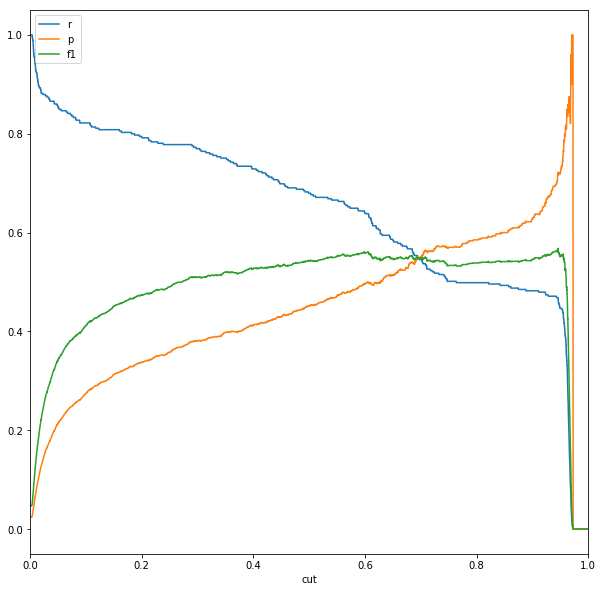

In [14]:
_ = cuts_df.plot(x='cut', y=['r', 'p', 'f1'], subplots=False, sharex=True, sharey=True, figsize=(10,10))

In [ ]:
_ = cuts_df[cuts_df['cut'] > 0.95].plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

# Qualitative Study on TEST dataset

In [ ]:
cuts_df[cuts_df['cut'] == 0.946]

In [ ]:
cut = 0.946

results = test_mix[test_mix['score'] > cut]

nb_found = {}
nb_returned = {}

for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
    nb_found[case_id] = found
for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
    nb_returned[case_id] = returned

recall = {}
precision = {}
f1 = {}

d = []

for case_id, rels in nb_rels.items():
    found = nb_found[case_id] if case_id in nb_found else 0
    returned = nb_returned[case_id] if case_id in nb_returned else 0
    r = found / rels
    p = found / returned if returned > 0 else 0
    recall[case_id] = r
    precision[case_id] = p
    f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0
    d.append([case_id, r, p, f1[case_id], returned, found, rels])
    


In [ ]:
df = pd.DataFrame(d, columns=['case_id', 'r', 'p', 'f1', 'returned', 'found', 'rels'])
df.to_csv('test_results.csv', index=False)

In [ ]:
_ = df[['r', 'p', 'f1']].plot.hist(bins=10, density=True, subplots=True, layout=(3,1), figsize=(10,30))

In [ ]:
_ = df[['returned', 'found']].plot.hist(bins=10, density=True, subplots=True, layout=(2,1), figsize=(10,20))

In [ ]:
df[df['f1'] > 0.9]

In [ ]:
test_mix[(test_mix['case_id'] == 14)].sort_values('score', ascending=False)

## Study of cutting at a score with HIGH precision
Check how many records are returned (P@1 or P@2 can be very high, but that's not helping a lot)

In [ ]:
plt.figure(figsize=(12,12))
_ = plt.hist(x=[v for _,v in returned_at_cut[0.97].items()], bins=[i for i in range(0,16)], density=True)
plt.grid()

In [ ]:
cuts_df[cuts_df['cut'] == 0.96]

## ROC CURVE

In [ ]:
# Compute ROC curve and ROC area for each class
y_test = np.expand_dims(test_mix['candidate_is_noticed'].values, axis=1)
y_score = np.expand_dims(test_mix['score'].values, axis=1)

print('y_test: {}'.format(y_test.shape))
print('y_score: {}'.format(y_score.shape))
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure(figsize=(12,12))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# CUTTING BY RANK

In [ ]:
cuts = []
ranked = test_mix.sort_values(by=['case_id', 'score'], ascending=[True, False])
ranked['rank'] = list(np.arange(1, number_candidates+1, 1)) * number_cases

for cut in np.arange(1, number_candidates+1, 1):
    results = ranked[ranked['rank'] <= cut]

    nb_found = {}
    nb_returned = {}

    for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
        nb_found[case_id] = found
    for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
        nb_returned[case_id] = returned

    recall = {}
    precision = {}
    f1 = {}

    for case_id, rels in nb_rels.items():
        found = nb_found[case_id] if case_id in nb_found else 0
        returned = nb_returned[case_id] if case_id in nb_returned else 0
        r = found / rels
        p = found / returned if returned > 0 else 0
        recall[case_id] = r
        precision[case_id] = p
        f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        # MACRO Average
        #avg_r = sum([v for _,v in recall.items()]) / len(recall)
        #avg_p = sum([v for _,v in precision.items()]) / len(precision)
        #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p)

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut, avg_r, avg_p, avg_f1])

rank_cuts_df = pd.DataFrame(cuts, columns=['cut', 'r', 'p', 'f1'])
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, rank_cuts_df.sort_values(metric, ascending=False)[['cut', metric]][:1]))

# Best at F1
best_f1 = rank_cuts_df.sort_values('f1', ascending=False)[['cut', metric]][:1]['cut'].values[0]
print('Values at best cut: R={:0.2f} P={:0.2f}'.format(rank_cuts_df[rank_cuts_df['cut'] == best_f1]['r'].values[0], 
                                                       rank_cuts_df[rank_cuts_df['cut'] == best_f1]['p'].values[0]))

In [ ]:
_ = rank_cuts_df.plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

In [ ]:
_ = rank_cuts_df[rank_cuts_df['cut'] <= 10].plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

In [ ]:
rank_cuts_df[rank_cuts_df['cut'].isin([5,10,15,20])].set_index('cut')

## Plot as a % of the max possible performance

### Max Recall / Precision @K because of RELS distribution
What would be the Recall / Precision of the perfect ranker if we cut @K ??

In [ ]:
max_metrics_by_rank = {}
all_relevant = sum([v for _,v in nb_rels.items()])
for k in range(1, number_candidates+1, 1):
    all_returned = number_cases * k
    all_retrieved_in_k = sum([min([v,k]) for _,v in nb_rels.items()])
    
    r = all_retrieved_in_k / all_relevant
    p = all_retrieved_in_k / all_returned
    f1 = 2*p*r/(p+r)

    at_rank = {
        'r': r,
        'p': p,
        'f1': f1
    }
    max_metrics_by_rank[k] = at_rank
    

In [ ]:
for metric in ['r', 'p', 'f1']:
    rank_cuts_df['{}_rel'.format(metric)] = rank_cuts_df.apply(lambda x: x[metric] / max_metrics_by_rank[x['cut']][metric], axis=1)

In [ ]:
_ = rank_cuts_df[rank_cuts_df['cut'] <= 50].plot(x='cut', y=['r_rel', 'p_rel', 'f1_rel'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

In [ ]:
0.44/0.61